# Testing for COVID-19 using Chest X-Rays

In this notebook, I train a Deep CNN to detect COVID-19 from Chest X-Ray images.

Dataset Used: https://github.com/ieee8023/covid-chestxray-dataset

Pretrained CheXNet: https://github.com/brucechou1983/CheXNet-Keras/ 

Reference: https://www.pyimagesearch.com/2020/03/16/detecting-covid-19-in-x-ray-images-with-keras-tensorflow-and-deep-learning/

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.layers import AveragePooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input, GlobalAveragePooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import importlib
import random
import shutil
import cv2
import os

Using TensorFlow backend.


In [ ]:
def ceildiv(a, b):
    return -(-a // b)

def plots_from_files(imspaths, figsize=(10,5), rows=1, titles=None, maintitle=None):
    """Plot the images in a grid"""
    f = plt.figure(figsize=figsize)
    if maintitle is not None: plt.suptitle(maintitle, fontsize=10)
    for i in range(len(imspaths)):
        sp = f.add_subplot(rows, ceildiv(len(imspaths), rows), i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        img = plt.imread(imspaths[i])
        plt.imshow(img)

In [ ]:
dataset_path = "/content/drive/My Drive/model/dataset"

In [ ]:
normal_images = list(paths.list_images(f"{dataset_path}/normal"))
covid_images = list(paths.list_images(f"{dataset_path}/covid"))

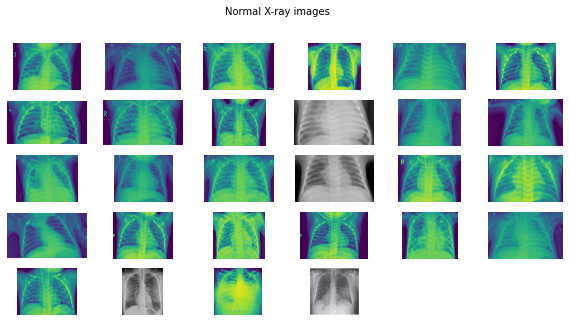

In [ ]:
plots_from_files(normal_images, rows=5, maintitle="Normal X-ray images")

In [ ]:
INIT_LR = 1e-3
EPOCHS = 100
BS = 8

In [ ]:
print("[INFO] loading images...")
imagePaths = list(paths.list_images(dataset_path))
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    data.append(image)
    labels.append(label)

data = np.array(data) / 255.0
labels = np.array(labels)

# Normalize with Image Net Mean
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])
data = (data - imagenet_mean) / imagenet_std

[INFO] loading images...


In [ ]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.15, stratify=labels, random_state=15)
# initialize the training data augmentation object
trainAug = ImageDataGenerator(fill_mode="nearest",
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,shear_range=0.2, zoom_range=0.2
  )

In [ ]:
class ModelFactory:
    """
    Model facotry for Keras default models
    """

    def __init__(self):
        self.models_ = dict(
            VGG16=dict(
                input_shape=(224, 224, 3),
                module_name="vgg16",
                last_conv_layer="block5_conv3",
            ),
            VGG19=dict(
                input_shape=(224, 224, 3),
                module_name="vgg19",
                last_conv_layer="block5_conv4",
            ),
            DenseNet121=dict(
                input_shape=(224, 224, 3),
                module_name="densenet",
                last_conv_layer="bn",
            ),
            ResNet50=dict(
                input_shape=(224, 224, 3),
                module_name="resnet50",
                last_conv_layer="activation_49",
            ),
            InceptionV3=dict(
                input_shape=(299, 299, 3),
                module_name="inception_v3",
                last_conv_layer="mixed10",
            ),
            InceptionResNetV2=dict(
                input_shape=(299, 299, 3),
                module_name="inception_resnet_v2",
                last_conv_layer="conv_7b_ac",
            ),
            NASNetMobile=dict(
                input_shape=(224, 224, 3),
                module_name="nasnet",
                last_conv_layer="activation_188",
            ),
            NASNetLarge=dict(
                input_shape=(331, 331, 3),
                module_name="nasnet",
                last_conv_layer="activation_260",
            ),
        )

    def get_last_conv_layer(self, model_name):
        return self.models_[model_name]["last_conv_layer"]

    def get_input_size(self, model_name):
        return self.models_[model_name]["input_shape"][:2]

    def get_model(self, class_names, model_name="DenseNet121", use_base_weights=True,
                  weights_path=None, input_shape=None):

        if use_base_weights is True:
            base_weights = "imagenet"
        else:
            base_weights = None

        base_model_class = getattr(
            importlib.import_module(
                f"keras.applications.{self.models_[model_name]['module_name']}"
            ),
            model_name)

        if input_shape is None:
            input_shape = self.models_[model_name]["input_shape"]

        img_input = Input(shape=input_shape)

        base_model = base_model_class(
            include_top=False,
            input_tensor=img_input,
            input_shape=input_shape,
            weights=base_weights,
            pooling="avg")
        x = base_model.output
        predictions = Dense(len(class_names), activation="sigmoid", name="predictions")(x)
        model = Model(inputs=img_input, outputs=predictions)

        if weights_path == "":
            weights_path = None

        if weights_path is not None:
            print(f"load model weights_path: {weights_path}")
            model.load_weights(weights_path)
        return model

In [ ]:
ChexNetClassesName = ['Atelectasis','Cardiomegaly','Effusion','Infiltration','Mass','Nodule','Pneumonia','Pneumothorax','Consolidation','Edema','Emphysema','Fibrosis','Pleural_Thickening','Hernia']
model_factory = ModelFactory()

baseModel = model_factory.get_model(
        ChexNetClassesName,
        model_name="DenseNet121",
        use_base_weights=False,
        weights_path="/content/drive/My Drive/model/ChexNet.h5",
        input_shape=(224, 224, 3))


load model weights_path: /content/drive/My Drive/model/ChexNet.h5


In [ ]:
model = Sequential([Model(baseModel.inputs, baseModel.layers[-2].output)])

# for layer in model.layers:
#   layer.trainable = False

model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5))
# model.add(Dense(512, activation="relu"))
# model.add(Dropout(0.5))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(2, activation="softmax"))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_4 (Model)              (None, 1024)              7037504   
_________________________________________________________________
dense_7 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)              

In [ ]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=1e-9)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit_generator(
    trainAug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Epoch 1/100
5/5 [==============================] - 41s 8s/step - loss: 0.9489 - accuracy: 0.6410 - val_loss: 0.7301 - val_accuracy: 0.5556
Epoch 2/100
5/5 [==============================] - 2s 408ms/step - loss: 1.2724 - accuracy: 0.4872 - val_loss: 0.7337 - val_accuracy: 0.5556
Epoch 3/100
5/5 [==============================] - 2s 409ms/step - loss: 1.1436 - accuracy: 0.6250 - val_loss: 0.6806 - val_accuracy: 0.5556
Epoch 4/100
5/5 [==============================] - 2s 407ms/step - loss: 1.2071 - accuracy: 0.4872 - val_loss: 0.6888 - val_accuracy: 0.5556
Epoch 5/100
5/5 [==============================] - 2s 403ms/step - loss: 1.3688 - accuracy: 0.3846 - val_loss: 0.6772 - val_accuracy: 0.5556
Epoch 6/100
5/5 [==============================] - 2s 397ms/step - loss: 1.1382 - accuracy: 0.5128 - val_loss: 0.6892 - val_accuracy: 0.5556
Epoch 7/100
5/5 [==============================] - 2s 396ms/step - loss: 1.0310 - accuracy: 0.4615 - val_l

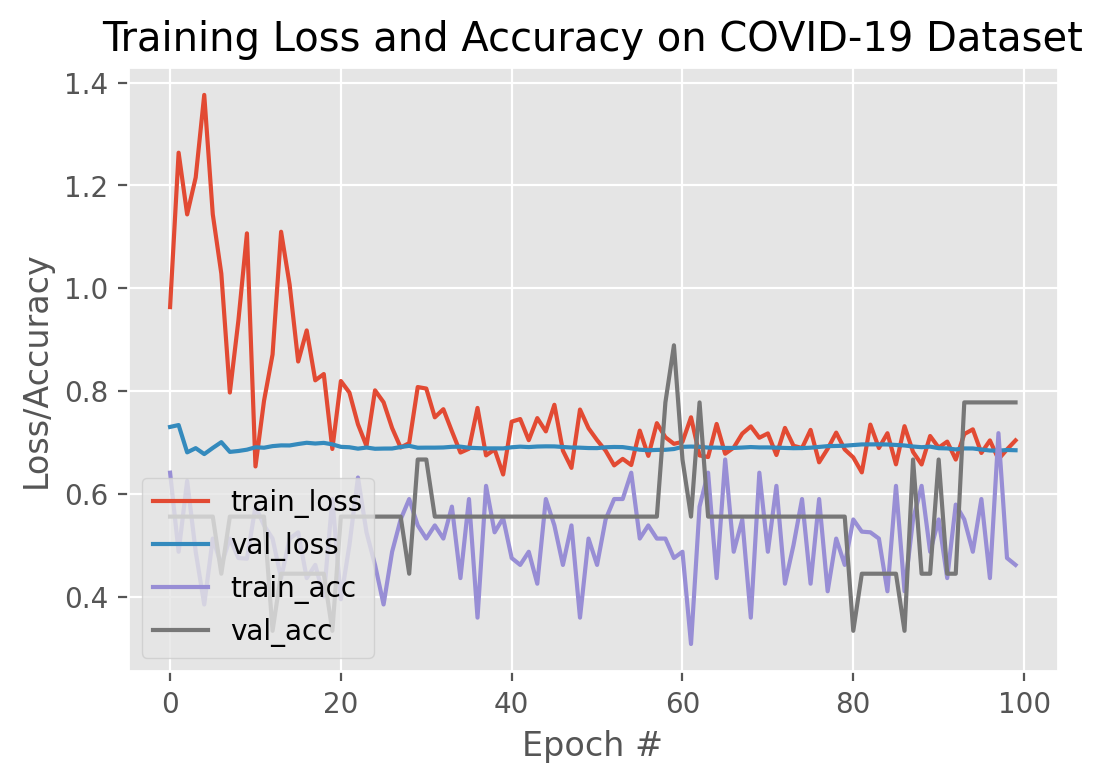

In [ ]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure(dpi=200)
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

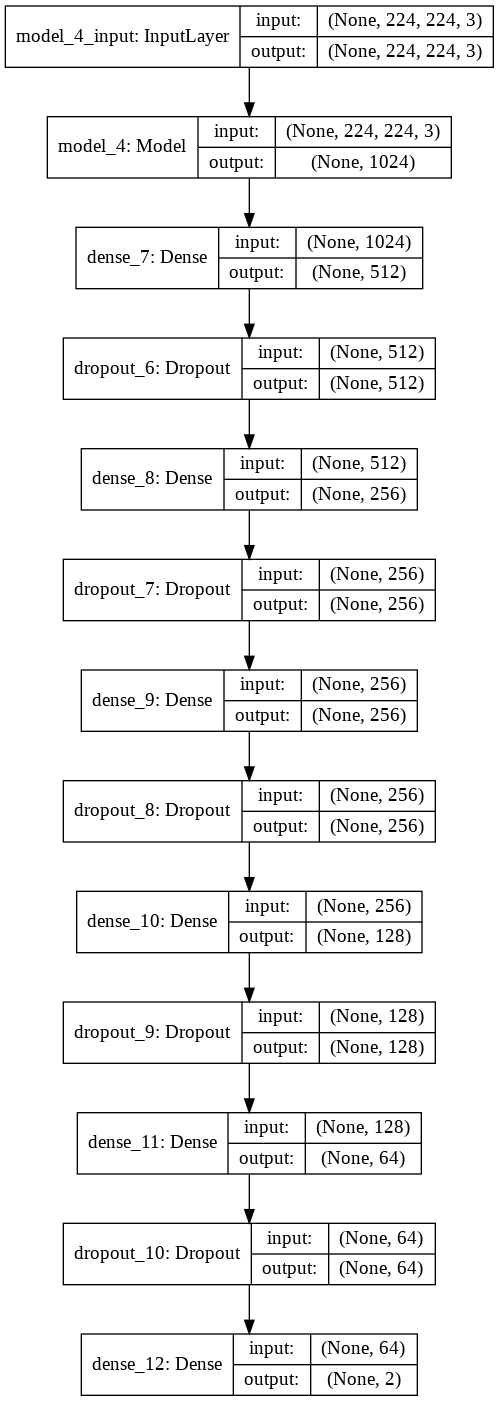

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

       covid       0.67      1.00      0.80         4
      normal       1.00      0.60      0.75         5

    accuracy                           0.78         9
   macro avg       0.83      0.80      0.77         9
weighted avg       0.85      0.78      0.77         9



In [ ]:
model.save('/content/drive/My Drive/model/covid_model_v5.h5') 

In [ ]:
model.summary()
new_model = model

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_4 (Model)              (None, 1024)              7037504   
_________________________________________________________________
dense_7 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)              

[[0.5118785  0.48812157]]
[0]


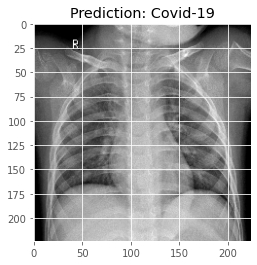

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image


img_width, img_height = 224, 224
img = image.load_img('/content/drive/My Drive/model/dataset/normal/IM-0466-0001.jpeg', target_size = (img_width, img_height))
x = image.img_to_array(img)
img = np.expand_dims(x, axis = 0) / 255.0

pred = new_model.predict(img)
print(pred)

print(np.argmax(pred, axis=1))
if np.argmax(pred, axis=1)[0] == 1:
    plt.title('Prediction: Non_Covid-19')
else:
    plt.title('Prediction: Covid-19')
plt.imshow(x/255.)
plt.savefig('plot_out.png')